# MMD vs. MMD+FR

In [1]:
# dependencies
import pandas as pd

In [2]:
# tool names
mmd = "mmd"
mmd_fr = "mmd+fr"

In [3]:
# Create a new DataFrame as a copy of the original
df = pd.read_csv('../evaluation/results.csv')

# MMD Parameter
df.loc[(df['learner'] == 0) & (df['rules'] == 'induction') & (df['coverage'] == 0.6), 'rules'] = mmd

# MMD+FR
df.loc[(df['learner'] == 3) & (df['rules'] == 'induction') & (df['coverage'] == 0.6), 'rules'] = mmd_fr

# Filter rows where rules is either 'mmd' or 'mmd+fr'
df = df[df['rules'].isin([mmd, mmd_fr])].reset_index()

In [4]:
df

,index,run,blackbox,model,learner,rules,coverage,seed,model_number,specificity_without,...,or_without,predicates_without,specificity_with,precision_with,recall_with,time_with,and_with,or_with,predicates_with,time_influential
0,45,1,bank,rfc,0,mmd,0.6,12345678,1,0.940,...,0,1,0.895,0.368,0.610,759.649,0,2,3,-1.000
1,46,1,bank,rfc,0,mmd,0.6,23456789,2,0.941,...,0,1,0.890,0.355,0.643,725.704,0,1,2,-1.000
2,47,1,bank,rfc,0,mmd,0.6,34567890,3,0.945,...,0,1,0.870,0.355,0.727,962.661,0,2,3,-1.000
3,48,1,bank,rfc,0,mmd,0.6,45678901,4,0.943,...,0,1,0.869,0.337,0.685,791.027,0,3,4,-1.000
4,49,1,bank,rfc,0,mmd,0.6,56789012,5,0.944,...,0,1,0.869,0.345,0.705,1006.451,0,3,4,-1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,17275,5,water,rfc,3,mmd+fr,0.6,12345678,1,0.236,...,0,1,0.160,0.355,0.949,35.141,0,1,2,0.570
546,17276,5,water,rfc,3,mmd+fr,0.6,23456789,2,0.230,...,0,1,0.375,0.361,0.764,13.219,1,1,3,0.442
547,17277,5,water,rfc,3,mmd+fr,0.6,34567890,3,0.235,...,0,1,0.220,0.362,0.899,24.906,1,1,3,0.554
548,17278,5,water,rfc,3,mmd+fr,0.6,45678901,4,0.240,...,0,1,0.217,0.381,0.892,9.861,1,2,4,0.433


## Calculate f1-scores

In [5]:
df['fscore'] = 2 * (df['precision_with'] * df['recall_with']) / (df['precision_with'] + df['recall_with'])

In [6]:
import pandas as pd
from scipy.stats import mannwhitneyu

def stats_for_subject(df):
    # split out the two rule‐sets
    a = df[df.rules==mmd]
    b = df[df.rules==mmd_fr]

    # medians
    prec_a, rec_a, f_a = a.precision_with.median(), a.recall_with.median(), a.fscore.median()
    prec_b, rec_b, f_b = b.precision_with.median(), b.recall_with.median(), b.fscore.median()

    # Mann‐Whitney U (only if both have >1 sample)
    if len(a.fscore)>1 and len(b.fscore)>1:
        _, p = mannwhitneyu(b.fscore, a.fscore)
    else:
        p = None

    return pd.Series({
        'mmd_precision': prec_a,
        'mmd_recall':  rec_a,
        'mmd_f1':    f_a,
        f'{mmd_fr}_prec': prec_b,
        f'{mmd_fr}_recall':  rec_b,
        f'{mmd_fr}_f1':    f_b,
        'p':         p
    })

# 1) compute per‐subject stats
results = df.groupby('blackbox').apply(stats_for_subject).reset_index()

In [7]:
results

,blackbox,mmd_precision,mmd_recall,mmd_f1,mmd+fr_prec,mmd+fr_recall,mmd+fr_f1,p
0,bank,0.355,0.685,0.459059,0.344,0.705,0.456196,0.330066
1,bugreport,0.227,0.736,0.346199,0.227,0.760,0.344828,0.813905
2,heartWT,0.465,0.800,0.600042,0.450,0.750,0.562500,0.631851
3,hotel,0.195,0.877,0.319058,0.202,0.812,0.324305,0.891484
4,java,0.195,0.373,0.245771,0.179,0.402,0.246869,0.089846
5,job,0.317,0.625,0.417895,0.413,0.456,0.431778,0.000004
6,php,0.136,0.627,0.225990,0.155,0.509,0.232556,0.014903
7,python,0.169,0.476,0.251482,0.196,0.382,0.259073,0.815016
8,ruby,0.144,0.614,0.233288,0.146,0.574,0.232789,0.266608
9,spam,0.379,0.624,0.471577,0.383,0.492,0.444281,0.000036


## Time

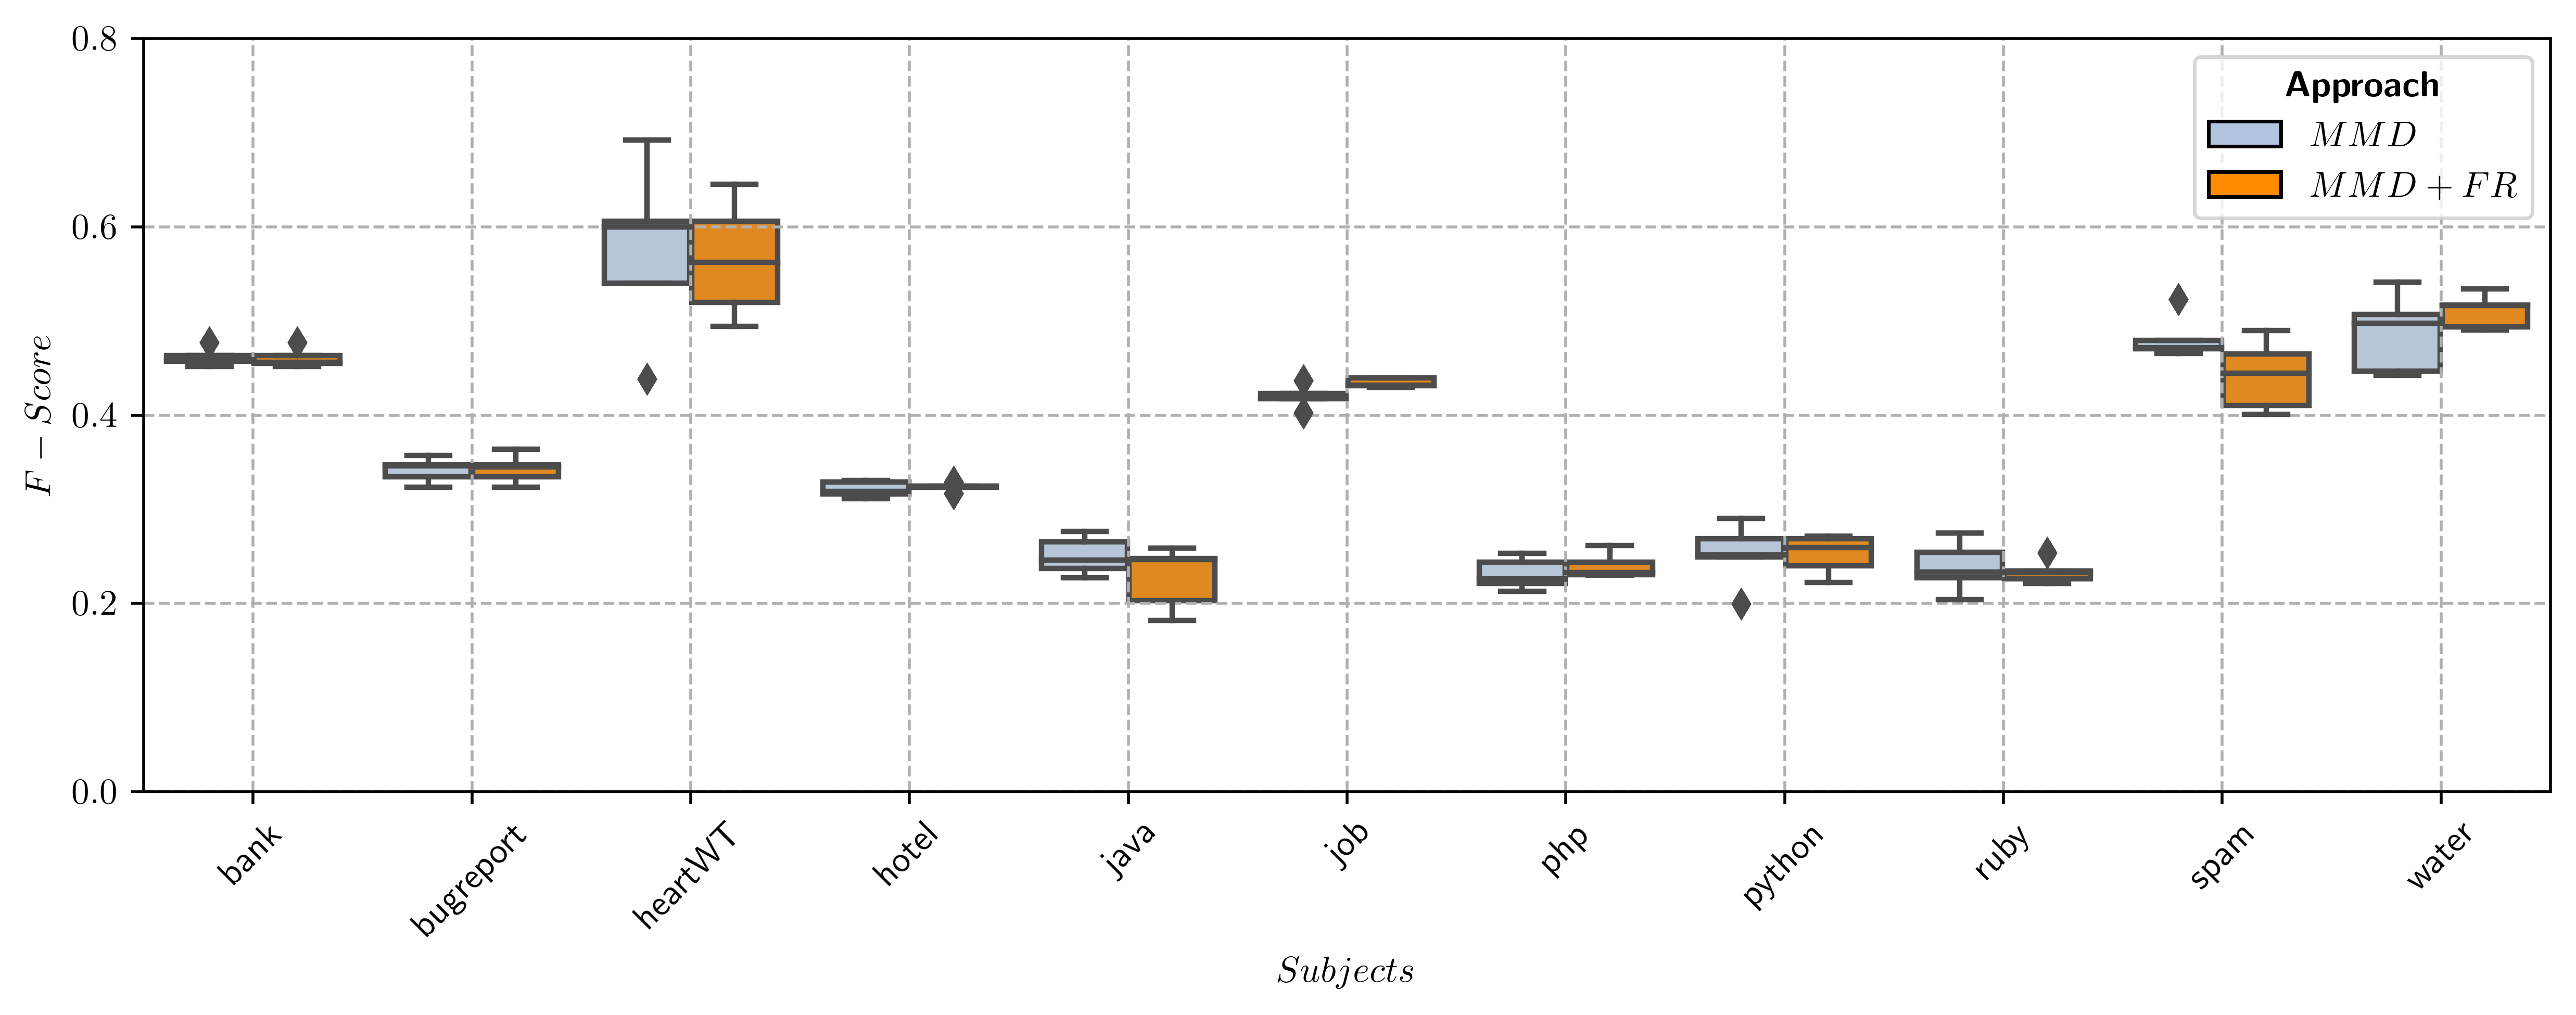

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Create the box plot
plt.figure(figsize=(10, 4), dpi=500)
plt.rcParams['text.usetex'] = True

# Define the colors
palette = {mmd_fr: 'darkorange', mmd: 'lightsteelblue'}

sns.boxplot(x='blackbox', y='fscore', hue='rules', data=df, palette=palette)
# plt.title('F-score Distribution by Subject for MMD and Our Approach')
plt.grid(axis="y", linestyle='--',)
plt.grid(axis="x", linestyle='--',which='both')
plt.xlabel(r'$Subjects$')
plt.ylabel(r'$F-Score$')
plt.yticks(np.arange(0, 0.81, 0.2))

plt.xticks(rotation=45)
first_patch = mpatches.Patch(ec="black" ,facecolor='lightsteelblue', label='Decision Tree')
second_patch = mpatches.Patch(ec="black" ,facecolor='darkorange',label=r'$MMD_{Feature}$')

plt.legend(title=r'\textbf{Approach}', labels=[r'$MMD$', r'$MMD+FR$'], handles=[first_patch,second_patch])
# plt.legend(handles=[first_patch, second_patch])
plt.tight_layout()
# plt.savefig('./RQ1-fscore.pdf')

In [9]:
import pandas as pd
from scipy.stats import mannwhitneyu

# assume mmd and mmd_fr are defined rule identifiers
# pivot to get lists of times per (subject, rule)
times = (
    df
    .groupby(['blackbox', 'rules'])['time_with']
    .apply(list)
    .unstack(fill_value=[])
)

def summarize_pair(x, y):
    """Run test on two lists x (MMD) and y (MMD+FR), return stats or None."""
    if len(x) < 2 or len(y) < 2:
        return None
    u_stat, p = mannwhitneyu(y, x, alternative='less')
    mmd_stats  = pd.Series(x).agg(['min','median','max'])
    fr_stats   = pd.Series(y).agg(['min','median','max'])
    imp_factor = round(mmd_stats['median'] / fr_stats['median'], 1) \
                 if fr_stats['median'] != 0 else float('inf')
    return {
        'u_statistic':    u_stat,
        'p_value':        p,
        'mmd_min':        mmd_stats['min'],
        'mmd_median':     mmd_stats['median'],
        'mmd_max':        mmd_stats['max'],
        f'{mmd_fr}_min':       fr_stats['min'],
        f'{mmd_fr}_median':    fr_stats['median'],
        f'{mmd_fr}_max':       fr_stats['max'],
                'significant':    p < 0.05,
        'improvement_factor': imp_factor
    }

# apply over each subject
rows = []
for subject, row in times.iterrows():
    x = row.get(mmd, [])
    y = row.get(mmd_fr, [])
    summary = summarize_pair(x, y)
    if summary:
        summary['subject'] = subject
        rows.append(summary)

results_df = pd.DataFrame(rows).set_index('subject')
# print(results_df)
results_df.drop(["u_statistic", "p_value"], axis=1)

,mmd_min,mmd_median,mmd_max,mmd+fr_min,mmd+fr_median,mmd+fr_max,significant,improvement_factor
subject,,,,,,,,
bank,695.454,791.027,1017.551,162.383,203.448,268.722,True,3.9
bugreport,223.582,352.162,576.908,17.937,37.575,53.945,True,9.4
heartWT,29.080,54.761,119.522,10.103,13.488,23.866,True,4.1
hotel,126.757,237.681,691.516,26.866,47.569,58.901,True,5.0
java,1778.969,2098.173,2589.793,325.901,424.383,811.743,True,4.9
job,121.029,144.736,177.839,80.101,93.463,133.297,True,1.5
php,753.267,1877.204,2452.397,154.542,235.208,659.542,True,8.0
python,1712.668,1944.548,3617.207,210.930,316.390,365.183,True,6.1
ruby,1942.289,2277.169,4196.548,224.519,431.725,642.835,True,5.3
